# Data Science Essentials: GeoPandas
    <Name> Dallin Stewart
    <Class> ACME 002
    <Date> Strength before weakness

In [5]:
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

In [6]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

In [7]:
# create a geo data frame with the coordinates of all the airports
airports = pd.read_csv("/mnt/c/Users/dalli/source/acme_senior/volume3/byu_vol3/Pandas4/airports.csv")
airports['Coordinates'] = list(zip(airports.Longitude, airports.Latitude))
airports['Coordinates'] = airports.Coordinates.apply(Point)
airports = gpd.GeoDataFrame(airports, geometry='Coordinates')

In [8]:
# create the convex hulls
hull1 = airports.loc[airports["Name"].isin(first_set)]["Coordinates"].values.unary_union().convex_hull
hull2 = airports.loc[airports["Name"].isin(second_set)]["Coordinates"].values.unary_union().convex_hull
hull3 = airports.loc[airports["Name"].isin(third_set)]["Coordinates"].values.unary_union().convex_hull

/tmp/ipykernel_7802/126230138.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


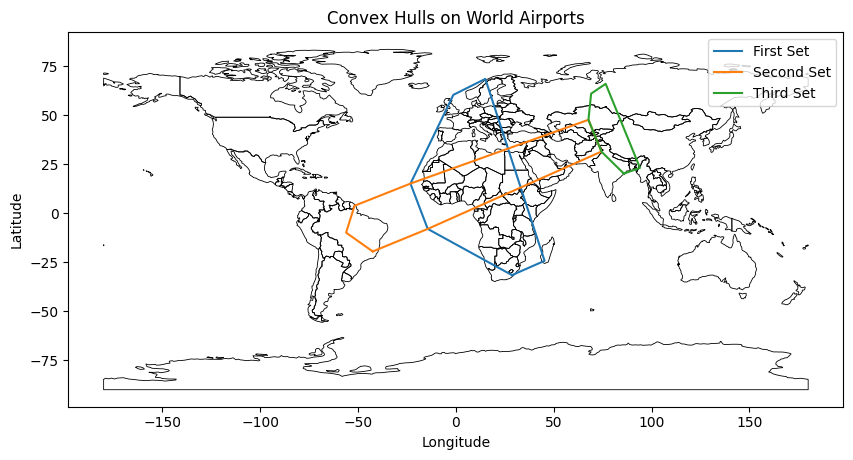

In [9]:
# Set outline of world countries as base
fig, ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=0.6)

# Plot airport convex hulls on top of world map
plt.plot(*hull1.exterior.xy, label="First Set")
plt.plot(*hull2.exterior.xy, label="Second Set")
plt.plot(*hull3.exterior.xy, label="Third Set")

# set plot parameters
plt.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Convex Hulls on World Airports')
plt.show()

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

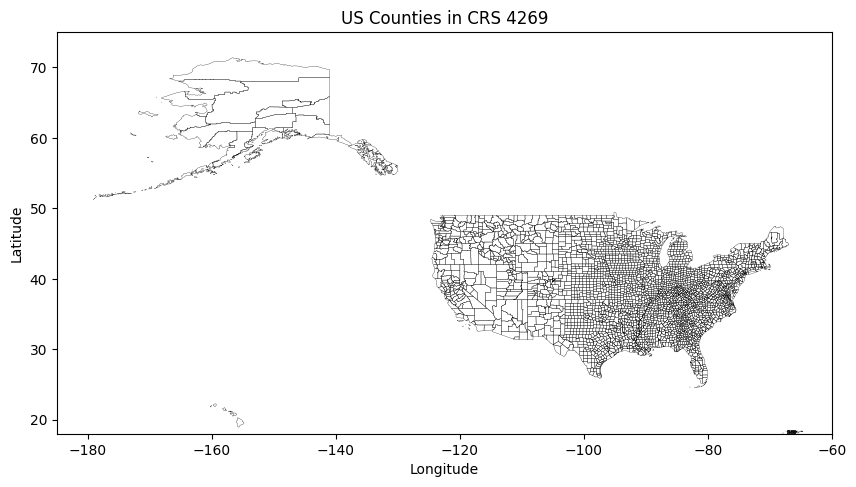

In [10]:
# read data
counties = gpd.read_file('/mnt/c/Users/dalli/source/acme_senior/volume3/byu_vol3/Pandas4/county_data.gpkg')

# plot default map
fig,ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
base = counties["geometry"].boundary.plot(edgecolor='black', ax=ax, linewidth=0.2)

# set plot parameters
plt.title('US Counties in CRS 4269')
plt.xlim(-185,-60)
plt.ylim(18,75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

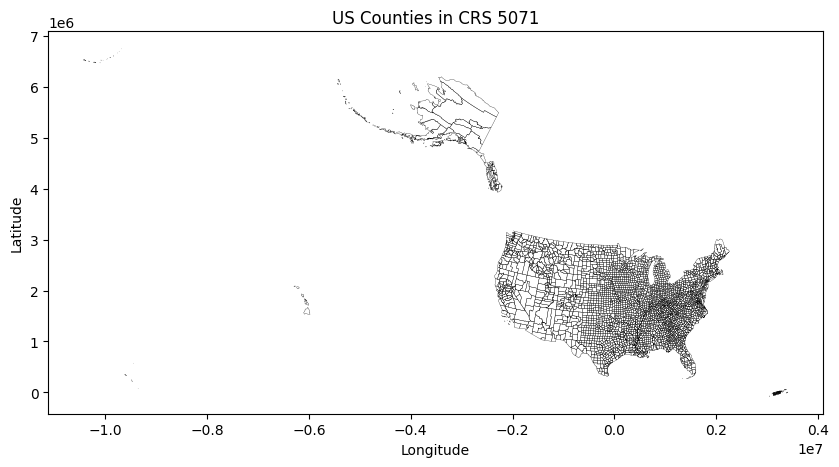

In [11]:
# plot other formatting
counties.to_crs(5071,inplace=True)
fig, ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
base = counties["geometry"].boundary.plot(edgecolor='black', ax=ax, linewidth=0.2)

# set plot parameters
plt.title('US Counties in CRS 5071')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

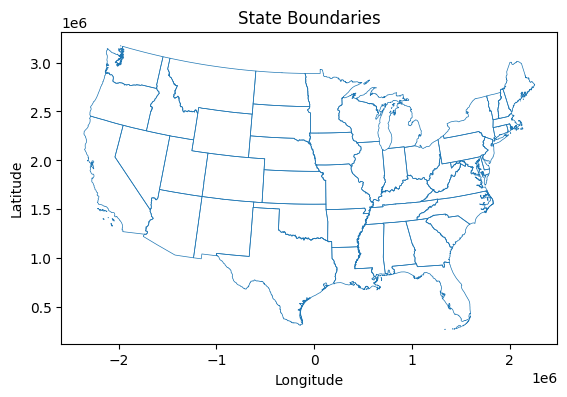

In [12]:
# load data
states = gpd.read_file('/mnt/c/Users/dalli/source/acme_senior/volume3/byu_vol3/Pandas4/county_data.gpkg')
states.to_crs(5071,inplace=True)

# drop unwanted regions
states = states[~states['STATEFP'].isin(['02', '15', '60', '66', '69', '72', '78'])]

# merge columns in the same state
states = states.dissolve(by='STATEFP')

# plot
base = states.boundary.plot(linewidth=0.5)
plt.title('State Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will not use rows in the Covid-19 DataFrame with unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska and rows with unknown FIPS codes.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases on March 21, 2020 along with its case count.**

In [13]:
# load data
covid = pd.read_csv('/mnt/c/Users/dalli/source/acme_senior/volume3/byu_vol3/Pandas4/nytimes.csv')

# create fips column and convert it to numbers
counties['fips'] = counties['STATEFP'] + counties['COUNTYFP']
counties['fips'] = pd.to_numeric(counties['fips'])

# merge covid and counties on fips
merged = covid.merge(counties, on='fips')
merged = merged[~merged['state'].isin(['Hawaii', 'Alaska'])]

# convert date columne and create gdf
merged.set_index(pd.to_datetime(merged['date']),inplace=True)
merged.drop(columns='date',inplace=True)
merged = gpd.GeoDataFrame(merged, geometry='geometry')

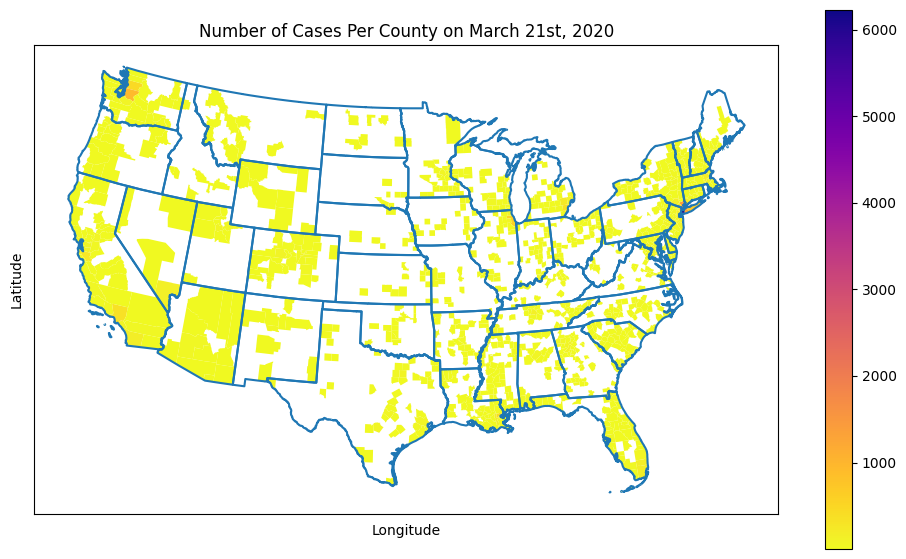

In [14]:
# state boundaries
base = states.boundary.plot(figsize=(12, 7))

# plot data
merged.loc['2020-03-21'].plot(ax=base,column='cases',cmap='plasma_r', legend=True)

# set plot parameters
plt.xticks([])
plt.yticks([])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Number of Cases Per County on March 21st, 2020')
plt.show()

In [15]:
# find the worst state
bad_state = np.argmax(merged.loc['2020-03-21']['cases'])
print(merged.loc['2020-03-21'].iloc[bad_state]['county'], "has the most cases with a total of", np.max(merged.loc['2020-03-21']['cases']))

New York City has the most cases with a total of 6226


## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

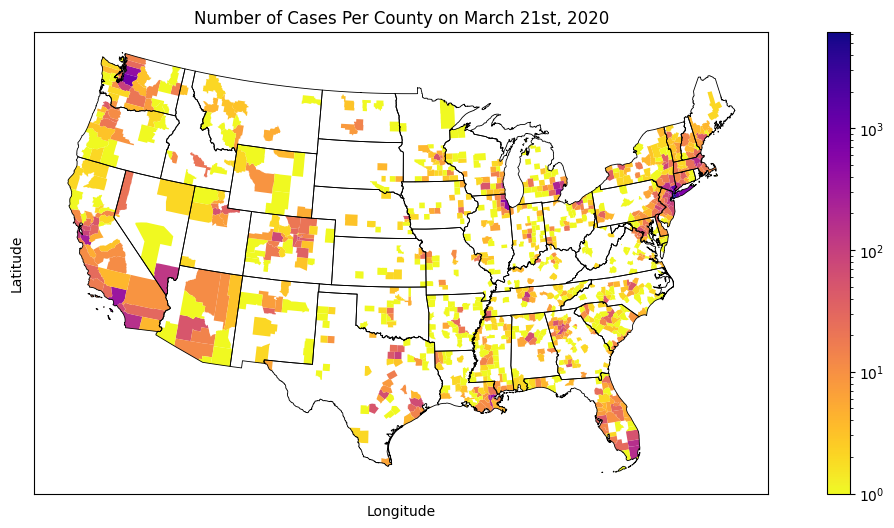

In [16]:
# state boundaries
fig, ax = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
base = states.boundary.plot(edgecolor='black', ax=ax, linewidth=0.6)

# set norm
data = merged.loc['2020-03-21'].cases
norm = LogNorm(vmin=min(data), vmax=max(data))

# plot data
merged.loc['2020-03-21'].plot(ax=ax,column='cases',cmap='plasma_r', legend=True, norm=norm)

# set plot parameters
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title('Number of Cases Per County on March 21st, 2020')
plt.show()

## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation and embed it.

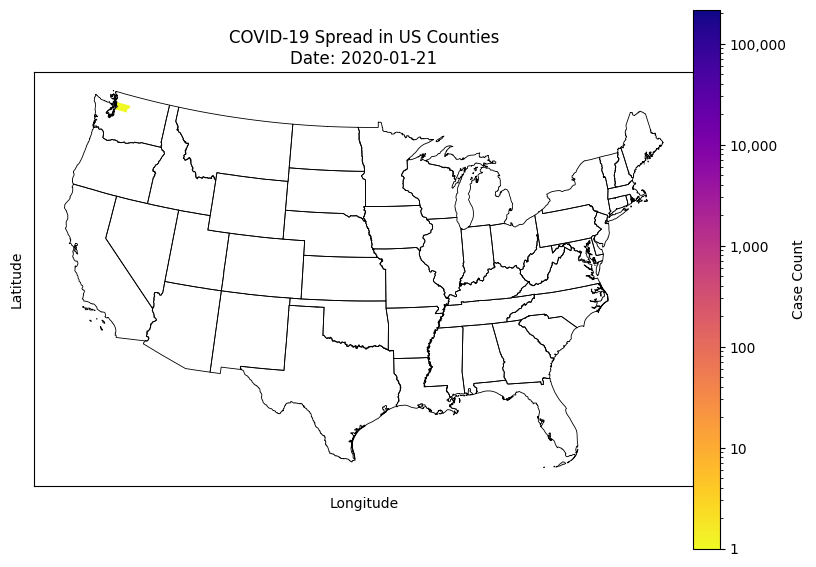

In [34]:
# Set up the figure and norm
fig, ax = plt.subplots(figsize=(10, 7), ncols=1, nrows=1)
base = states.boundary.plot(edgecolor='black', ax=ax, linewidth=0.6)
norm = LogNorm(vmin=1, vmax=merged['cases'].max())

# Define the update function
def update(date):
    ax.clear()
    base = states.boundary.plot(edgecolor='black', ax=ax, linewidth=0.6)
    merged[merged.index == date].plot(ax=ax, column="cases", cmap="plasma_r", norm=norm)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"COVID-19 Spread in US Counties\nDate: {date.strftime('%Y-%m-%d')}")

# Set up the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='plasma_r'), ax=ax, orientation='vertical', pad=0, label='Case Count')
cbar.set_ticks([1, 10, 100, 1000, 10000, 100000])
cbar.set_ticklabels(['1', '10', '100', '1,000', '10,000', '100,000'])

# Create and embed the animation
timeline = pd.date_range(start=min(merged.index), end=max(merged.index), freq='D')
mate = animation.FuncAnimation(fig, update, frames=timeline, interval=100)


In [35]:
mate.save('/mnt/c/Users/dalli/source/acme_senior/vl3labs/Pandas4/covid_animation.mp4')

<Figure size 640x480 with 0 Axes>

<video src="covid_animation-2.mp4" controls title="Title"></video>